In [41]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier

In [42]:
sns.set(style="whitegrid")
method_scores = {}

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon


In [44]:
csv_files = list(Path(path).rglob("*.csv"))
df = pd.read_csv(csv_files[0])

In [45]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Предобработка

In [46]:
df['Legendary'] = df['Legendary'].astype(int)
df[['Type 1', 'Type 2']] = df[['Type 1', 'Type 2']].fillna("None")
le_dict = {col: LabelEncoder().fit(df[col]) for col in ['Type 1', 'Type 2']}
for col, le in le_dict.items():
    df[col] = le.transform(df[col])

X = df.drop(columns=['Name', 'Legendary'])
y = df['Legendary']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, random_state=42, test_size=0.3
)

Визуализация распределения классов

In [47]:
def plot_class_distribution(y_before, y_after, method):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    sns.countplot(x=y_before, ax=ax[0], palette="pastel")
    ax[0].set_title("До балансировки")
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(['Not Legendary', 'Legendary'])

    sns.countplot(x=y_after, ax=ax[1], palette="Set2")
    ax[1].set_title(f"После: {method}")
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['Not Legendary', 'Legendary'])
    plt.tight_layout()
    plt.show()

In [48]:
def evaluate_model(X_res, y_res, method):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    print(f"\n===== {method} =====")
    print(classification_report(y_test, y_pred, zero_division=0))
    method_scores[method] = f1_score(y_test, y_pred, average='macro')

До балансировки

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


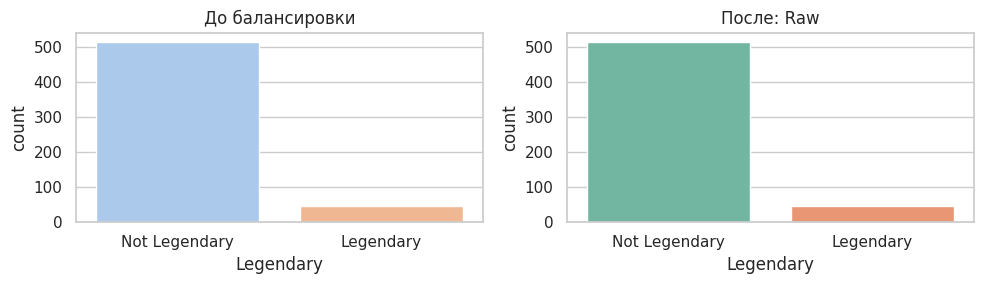

In [49]:
plot_class_distribution(y_train, y_train, "Raw")

# **Undersampling**

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


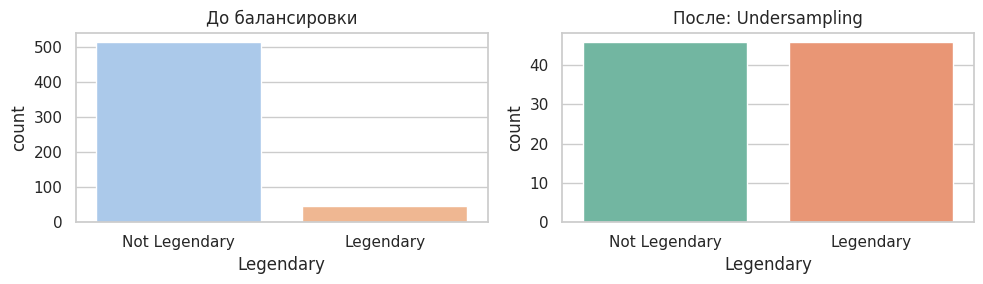


===== Undersampling =====
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       221
           1       0.54      1.00      0.70        19

    accuracy                           0.93       240
   macro avg       0.77      0.96      0.83       240
weighted avg       0.96      0.93      0.94       240



In [50]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_rus, "Undersampling")
evaluate_model(X_rus, y_rus, "Undersampling")

# **Oversampling**

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


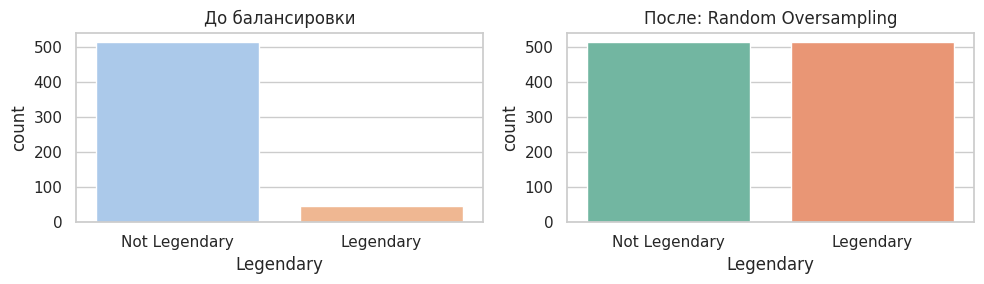


===== Random Oversampling =====
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       221
           1       0.67      0.95      0.78        19

    accuracy                           0.96       240
   macro avg       0.83      0.95      0.88       240
weighted avg       0.97      0.96      0.96       240



In [51]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_ros, "Random Oversampling")
evaluate_model(X_ros, y_ros, "Random Oversampling")

# **Class Weights (без ресемплинга)**

In [52]:
clf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)
print("\n===== Class Weights =====")
print(classification_report(y_test, y_pred_weighted, zero_division=0))
method_scores["Class Weights"] = f1_score(y_test, y_pred_weighted, average='macro')


===== Class Weights =====
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       221
           1       0.65      0.79      0.71        19

    accuracy                           0.95       240
   macro avg       0.82      0.88      0.84       240
weighted avg       0.96      0.95      0.95       240



# **SMOTE**

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


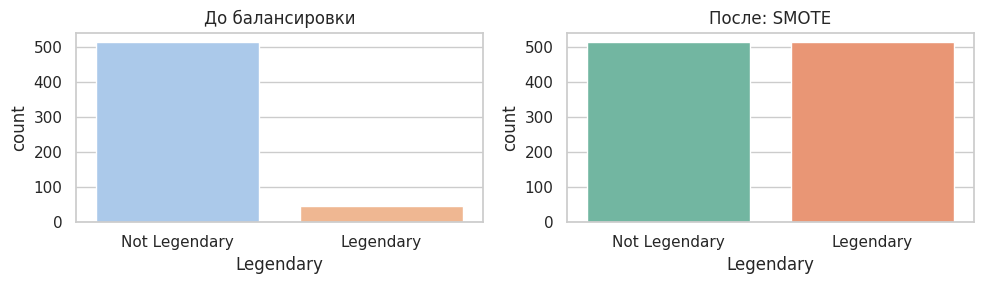


===== SMOTE =====
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       221
           1       0.59      0.89      0.71        19

    accuracy                           0.94       240
   macro avg       0.79      0.92      0.84       240
weighted avg       0.96      0.94      0.95       240



In [53]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_sm, "SMOTE")
evaluate_model(X_sm, y_sm, "SMOTE")

# **SMOTEENN**

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


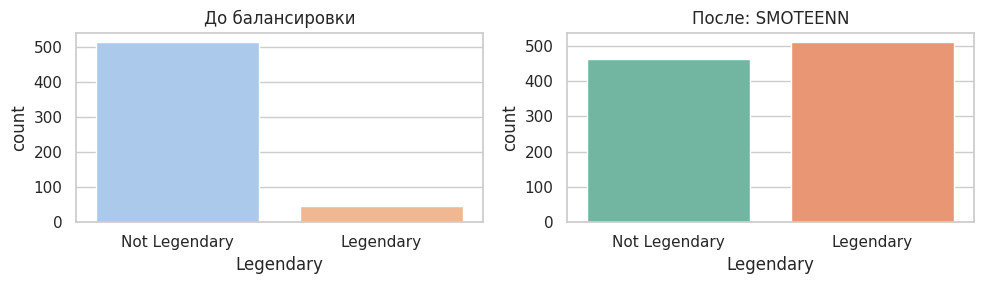


===== SMOTEENN =====
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       221
           1       0.55      0.95      0.69        19

    accuracy                           0.93       240
   macro avg       0.77      0.94      0.83       240
weighted avg       0.96      0.93      0.94       240



In [54]:
smoteenn = SMOTEENN(random_state=42)
X_smenn, y_smenn = smoteenn.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_smenn, "SMOTEENN")
evaluate_model(X_smenn, y_smenn, "SMOTEENN")

BorderlineSMOTE вместо ICOTE

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


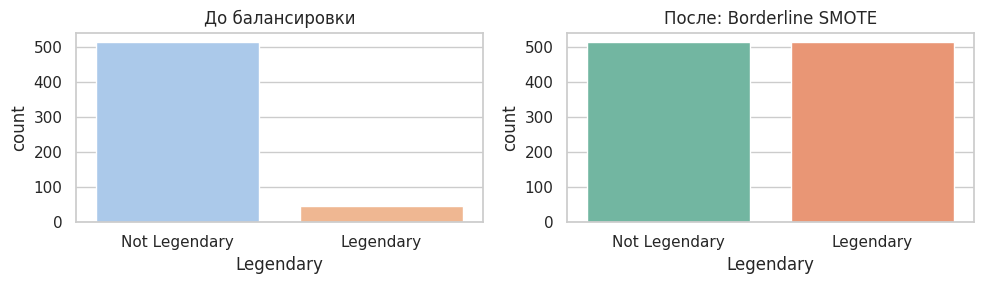


===== Borderline SMOTE =====
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       221
           1       0.60      0.95      0.73        19

    accuracy                           0.95       240
   macro avg       0.80      0.95      0.85       240
weighted avg       0.96      0.95      0.95       240



In [55]:
bsmote = BorderlineSMOTE(random_state=42)
X_bsm, y_bsm = bsmote.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_bsm, "Borderline SMOTE")
evaluate_model(X_bsm, y_bsm, "Borderline SMOTE")

TKRKNN через KMeansSMOTE

/tmp/ipython-input-47-2666565338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette="pastel")
/tmp/ipython-input-47-2666565338.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette="Set2")


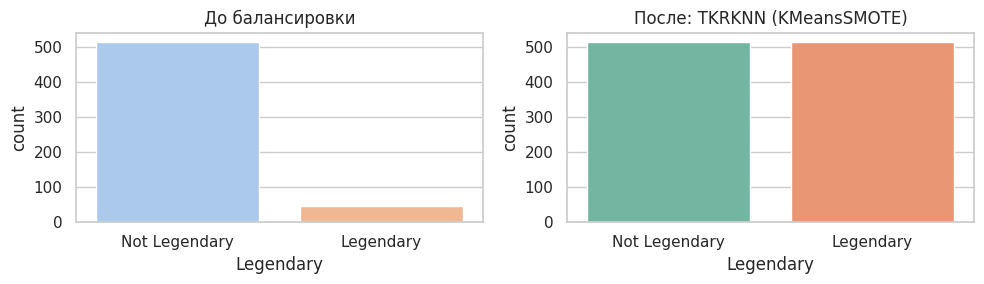


===== TKRKNN (KMeansSMOTE) =====
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       221
           1       0.62      0.84      0.71        19

    accuracy                           0.95       240
   macro avg       0.80      0.90      0.84       240
weighted avg       0.96      0.95      0.95       240



In [56]:
kmeans_smote = KMeansSMOTE(random_state=42, kmeans_estimator=3, cluster_balance_threshold=0.01)
X_tkrknn, y_tkrknn = kmeans_smote.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_tkrknn, "TKRKNN (KMeansSMOTE)")
evaluate_model(X_tkrknn, y_tkrknn, "TKRKNN (KMeansSMOTE)")

# **Balanced Random Forest**

In [57]:
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
print("\n===== Balanced Random Forest =====")
print(classification_report(y_test, y_pred_brf, zero_division=0))
method_scores["Balanced RF"] = f1_score(y_test, y_pred_brf, average='macro')


===== Balanced Random Forest =====
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       221
           1       0.54      1.00      0.70        19

    accuracy                           0.93       240
   macro avg       0.77      0.96      0.83       240
weighted avg       0.96      0.93      0.94       240



# **сравнение F1-score**

/tmp/ipython-input-58-2989968744.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(method_scores.keys()), y=list(method_scores.values()), palette="viridis")


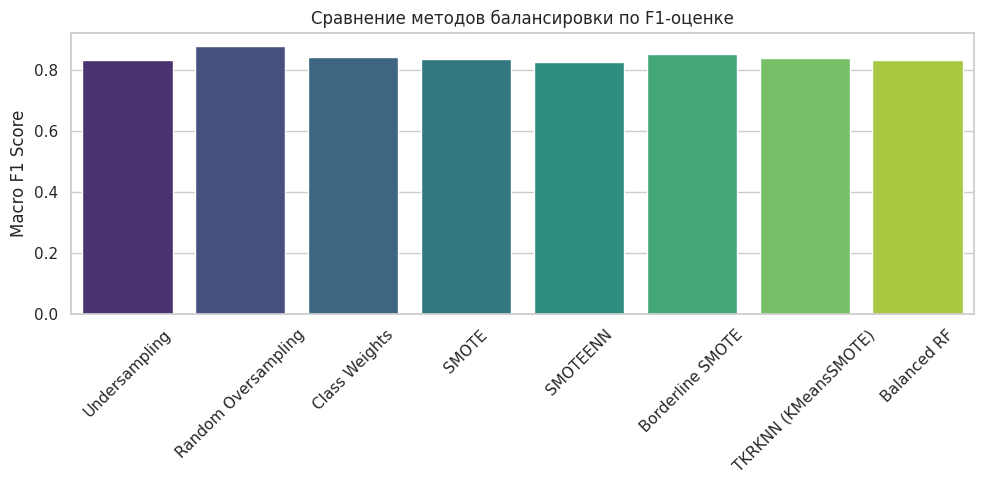

In [58]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(method_scores.keys()), y=list(method_scores.values()), palette="viridis")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.title("Сравнение методов балансировки по F1-оценке")
plt.tight_layout()
plt.show()
